In [1]:
from __future__ import print_function

import h5py, os, sys, glob
sys.path.append('../lib')

# to get newer sklearn for updated GradientBoostingRegressor options
# to get newer numpy for numpy.quantile
!pip install scikit-learn==0.20 --user
!pip install numpy==1.15 --user
sys.path.insert(0,'$HOME/.local/lib/python2.7/site-packages/')

import numpy as np

from glob import glob

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from prettytable import PrettyTable

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:12: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/uscms/home/jduarte1/.local/lib/python2

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
Mjj_selection = 700.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(209109, 13)


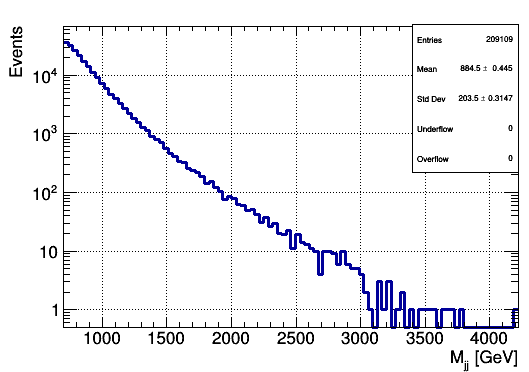

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
print(np.mean(y))

103.62135082607014


In [5]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=10,
                                tol=1e-5,
                                verbose=1)


gbr_cut.fit(x, y)

      Iter       Train Loss   Remaining Time 
         1           0.3818           18.66s
         2           0.3811           19.05s
         3           0.3806           18.97s
         4           0.3802           18.85s
         5           0.3798           18.75s
         6           0.3795           18.67s
         7           0.3792           18.59s
         8           0.3790           18.57s
         9           0.3788           18.55s
        10           0.3786           18.53s
        20           0.3774           15.99s
        30           0.3770           13.42s


GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             n_iter_no_change=10, presort='auto', random_state=None,
             subsample=1.0, tol=1e-05, validation_fraction=0.5, verbose=1,
             warm_start=False)

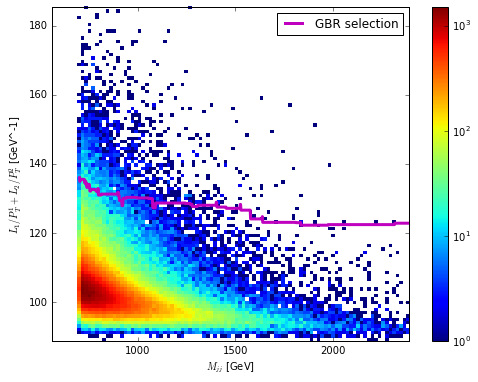

In [6]:
plt.figure(figsize=(8, 6))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-x_min))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [7]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

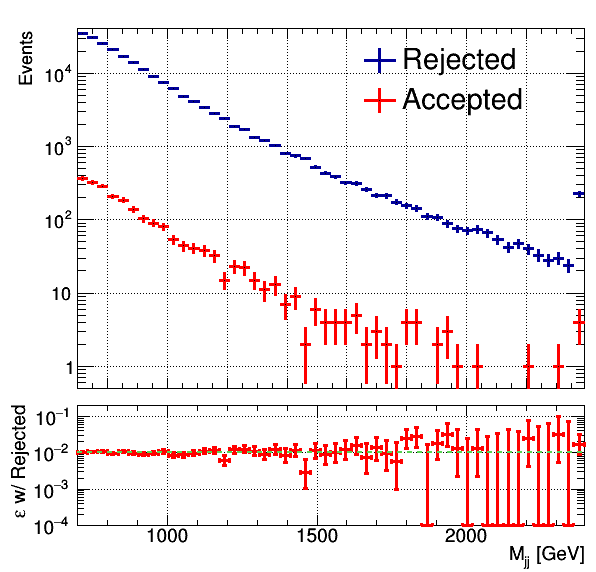

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)
h_a = create_TH1D(x[sel], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(2)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(x[np.logical_not(sel)], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c.pad1.SetLogy()
c.pad2.SetLogy()

c.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c.Draw()

In [9]:
import scipy as sp
def HypotesisTets(h_a, h_r, eff, N_asymov = 100000, show_hist = False):
    aux, _ = rootTH1_to_np(h_r)
    nu = eff*aux/(1-eff)
    
    o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
    
    probs = sp.stats.poisson.pmf(o_asymov, nu)
    nll = -np.log(probs)
    s_asymov = np.sum(nll, axis=-1)
    
    aux, _ = rootTH1_to_np(h_a)
    probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
    p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
    
    if show_hist:
        plt.hist(s_asymov)

    return p_val

In [10]:
HypotesisTets(h_a, h_r, SM_eff)

0.45698

# Prepare combine inputs in signal region

### Get the data

In [11]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':'QCD',
                'AtoZZZ':'$A\toZZZ$',
                'GtoWW':'$G\toWW$',
                'GtoBtt':'$G_{B}\tot\bar{t}$',
                'GtoNtt':'$G_{N}\tot\bar{t}$'
               }

BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

In [ ]:
data = {}
table = PrettyTable()
table.field_names = ['Sample', 'Tot. evts', 'Sel. evts', 'Eff VAE[%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.3f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], np.sum(data[n]['sel']), eff])
    
print(table)

### See the distributions and dump (scaled) histograms into ROOT file

In [ ]:
binning=[50, Mjj_selection, np.quantile(data['qcd']['mJJ'], 0.999)]

# scale factor to scale signal
scale = 0.01

datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')

h_t = create_TH1D(data['qcd']['mJJ'], 
                  name='h_tot', title='Total',
                  binning=binning,
                  opt=''
                 )
h_t.SetLineColor(rt.kGreen)
h_t.SetStats(0)
h_t.Sumw2()


h_a = create_TH1D(data['qcd']['mJJ'][data['qcd']['sel']], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt=''
                 )
h_a.SetLineColor(rt.kGreen)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data['qcd']['mJJ'][np.logical_not(data['qcd']['sel'])], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt=''
                 )
h_r.SetLineColor(rt.kGreen)
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

datacard_hist.cd()
h_t.Write('qcd_tot')
h_a.Write('qcd_acc')
h_r.Write('qcd_rej')

h_t.Write('data_obs_tot')
h_a.Write('data_obs_acc')
h_r.Write('data_obs_rej')
h_t.SetDirectory(0)
h_a.SetDirectory(0)
h_r.SetDirectory(0)

for name_BSM in ['GtoWW']:
    print('\n'+name_BSM)
    
    
    h_t_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_t'+name_BSM,
                  binning=h_t.binning,
                  opt=''
                 )
    h_t_BSM.SetLineColor(rt.kBlue)
    h_t_BSM.Sumw2()
    h_t_BSM.Scale(scale)
    
    h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_a'+name_BSM,
                  binning=h_a.binning,
                  opt=''
                 )
    h_a_BSM.SetLineColor(rt.kBlue)
    h_a_BSM.Sumw2()
    h_a_BSM.Scale(scale)
    
    h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
                  name='h_r'+name_BSM,
                  binning=h_r.binning,
                  opt=''
                 )
    h_r_BSM.SetLineColor(rt.kBlue)
    h_r_BSM.Sumw2()
    h_r_BSM.Scale(scale)

    
    c_t = rt.TCanvas('c_t','c_t',500,400)
    h_t.Draw()
    h_t.SetMinimum(1)
    h_t_BSM.Draw('same')
    c_t.SetLogy()
    c_t.Draw()
    
    c_a = rt.TCanvas('c_a','c_a',500,400)
    h_a.Draw()
    h_a_BSM.Draw('same')
    c_a.SetLogy()
    c_a.Draw()
    
    c_r = rt.TCanvas('c_r','c_r',500,400)
    h_r.Draw()
    h_r_BSM.Draw('same')
    c_r.SetLogy()
    c_r.Draw()
    
    datacard_hist.cd()
    h_t_BSM.Write(name_BSM+'_tot')
    h_a_BSM.Write(name_BSM+'_acc')
    h_r_BSM.Write(name_BSM+'_rej')
    h_t_BSM.SetDirectory(0)
    h_a_BSM.SetDirectory(0)
    h_r_BSM.SetDirectory(0)
datacard_hist.Close()

## Define datacard based on histogram template fit

In [ ]:
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

In [ ]:
datacard_tot = datacard.format(BIN='tot',
                          OBS=h_t.Integral(),
                          QCDRATE=h_t.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_t_BSM.Integral())
print(datacard_tot)
with open('datacard_tot.txt','w') as f:
    f.write(datacard_tot)

datacard_acc = datacard.format(BIN='acc',
                          OBS=h_a.Integral(),
                          QCDRATE=h_a.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_a_BSM.Integral())
print(datacard_acc)
with open('datacard_acc.txt','w') as f:
    f.write(datacard_acc)

# Run combine

In [ ]:
# using "total" region
!combine -M AsymptoticLimits -d datacard_tot.txt -t -1

In [ ]:
# using "accept" signal region
!combine -M AsymptoticLimits -d datacard_acc.txt -t -1